# Chapter 1 Introduction

Sources:

- Dougherty et al (1995)

In [72]:
%matplotlib inline
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## One hot encode

In [54]:
corpus = ["Time flies like an arrow", "fruit flies like a banana"]
vocab = list(set(word.lower() for sentence in corpus for word in sentence.split()))
word_idx = {word:idx for idx, word in enumerate(vocab)}
idx_word = {idx:word for idx, word in enumerate(vocab)}

In [55]:
print(word_idx)
print(idx_word)

{'time': 0, 'an': 1, 'like': 2, 'fruit': 3, 'banana': 4, 'a': 5, 'arrow': 6, 'flies': 7}
{0: 'time', 1: 'an', 2: 'like', 3: 'fruit', 4: 'banana', 5: 'a', 6: 'arrow', 7: 'flies'}


In [56]:
onehot_vocab_ = torch.eye(len(vocab))
onehot_vocab_

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

In [57]:
onehot_vocab_[word_idx["time"]] # One hot encode for the word time

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
def encode(sentence):
    sentence_vector_idx = [word_idx[word.lower()] for word in sentence.split()]
    onehot_sentence = onehot_vocab_[sentence_vector_idx]
    return onehot_sentence

In [59]:
encode("flies like an") # A 3x8 matrix for the sentence one hot encode

tensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]])

In [60]:
encode("flies like an").sum(dim=0) # A 1 x 8 one hot binary representation

tensor([0., 1., 1., 0., 0., 0., 0., 1.])

## Binary one hot representation

vocab : ['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
one hot representation 
tensor([[1, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 1, 0]])


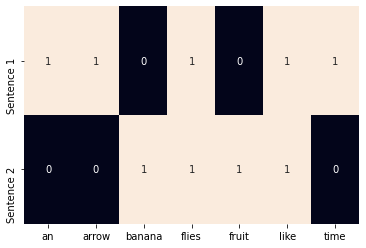

In [67]:
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]
one_hot_vectorizer = CountVectorizer(binary=True)
one_hot = torch.tensor(one_hot_vectorizer.fit_transform(corpus).toarray())
vocab = one_hot_vectorizer.get_feature_names()
print("vocab : {}".format(vocab))
print("one hot representation \n{}".format(one_hot))
sns.heatmap(one_hot, annot=True,
           cbar=False, xticklabels=vocab,
           yticklabels=["Sentence 1", "Sentence 2"])
plt.show()

## TF representation

vocab : ['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
tf representation 
tensor([[1, 1, 0, 2, 0, 1, 1],
        [0, 0, 1, 1, 1, 1, 0]])


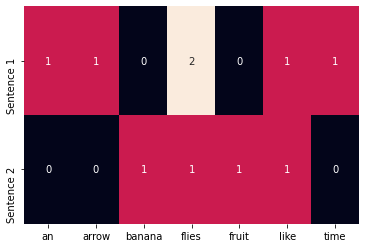

In [82]:
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]
tf_vectorizer = CountVectorizer()
tf_representation = torch.tensor(tf_vectorizer.fit_transform(corpus).toarray())
vocab = tf_vectorizer.get_feature_names()
print("vocab : {}".format(vocab))
print("tf representation \n{}".format(tf_representation))
sns.heatmap(tf_representation, annot=True,
           cbar=False, xticklabels=vocab,
           yticklabels=["Sentence 1", "Sentence 2"])
plt.show()

## TFIDF representation

The IDF representation penalizes common tokens and rewards rare tokens in the vector representation. 
The TF representation penalizes rare tokens and rewards common tokens in the vector representation.

$$IDF(w) = log(\frac{N}{n_w})$$

Where $N$ is the total number of documents and $n_w$ is the number of documents containing the word $w$.

Then TFIDF is simpy the product of TF and IDF:
$$TF(w) * IDF(w)$$

Let's see the limits:

- Case 1: the word occur in every document $n_w = N$ then $IDF(w) = log(1) = 0$ completly penalizing that word.
- Case 2: the word occur just one time in a document $IDF(w) = log(N)$ will be the maximun value for the weight of that word.

vocab : ['an', 'arrow', 'banana', 'flies', 'fruit', 'like', 'time']
tfidf representation 
tensor([[0.4252, 0.4252, 0.0000, 0.6051, 0.0000, 0.3025, 0.4252],
        [0.0000, 0.0000, 0.5762, 0.4099, 0.5762, 0.4099, 0.0000]],
       dtype=torch.float64)


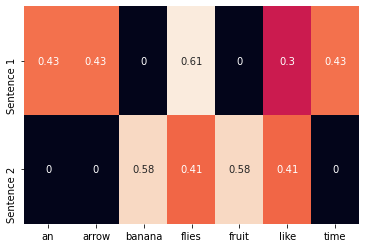

In [86]:
corpus = ["Time flies flies like an arrow",
         "Fruit flies like a banana"]
tfidf_vectorizer = TfidfVectorizer()
tfidf_representation = torch.tensor(tfidf_vectorizer.fit_transform(corpus).toarray())
vocab = tfidf_vectorizer.get_feature_names()
print("vocab : {}".format(vocab))
print("tfidf representation \n{}".format(tfidf_representation))
sns.heatmap(tfidf_representation, annot=True,
           cbar=False, xticklabels=vocab,
           yticklabels=["Sentence 1", "Sentence 2"])
plt.show()